In [1]:
import pandas as pd

In [2]:
img_level_stats = pd.read_csv('./results/data_analysis/image_level_statistics.csv')

In [3]:
turtletoise_score = pd.read_csv('./results/f_rcnn/second_stage/crop_imgs_logs_test.csv')
turtletoise_score.columns = ['img_name', 'Turtletoise']

In [4]:
test_imgs = pd.merge(img_level_stats.loc[img_level_stats['sample'] == 'test', 
                                         ['img_name', 'WnID', 'Species']],
                     turtletoise_score, on='img_name')

# Look at a sample of test images

In [5]:
seed = 9222017

In [6]:
test_sample = test_imgs.sample(n=20, random_state=seed)

In [7]:
test_sample

,img_name,WnID,Species,Turtletoise
3016,n01668892_3230,n01668892,Cooter,0.994925
2603,n01667778_5245,n01667778,Terrapin,0.959516
759,n01668665_5086,n01668665,Slider,0.978199
3733,n01669191_5857,n01669191,Box Turtle,0.995676
2305,n01671125_8113,n01671125,Gopher Tortoise,0.974023
3098,n01668892_8072,n01668892,Cooter,0.992229
3579,n01671479_1473,n01671479,Desert Tortoise,0.989091
812,n01668665_9070,n01668665,Slider,0.987798
95,n01664674_1539,n01664674,Pacific Ridley,0.995359
2502,n01667778_11455,n01667778,Terrapin,0.990240


# Had a look and decided which of these to keep

In [8]:
free_form_imgs = ['n01665541_4667', 'n01665541_11745', 'n01671479_2675', 'n01670802_1937', 
                  'n01667778_11455', 'n01669191_5857', 'n01664674_1539', 'n01667114_4665']

In [9]:
test_sample = test_sample[test_sample['img_name'].isin(free_form_imgs)]

In [10]:
def row_to_img_path(row, original=True):
    import os
    if original:
        ext = '.JPEG'
        folder = './data/images/test/'
    else:
        ext = '.png'
        folder = './data/f_rcnn_second_stage/test/'
    path = os.path.join(folder,
                        row[1]['WnID'], 
                        row[1]['img_name'] + ext)
    return path

In [11]:
img_paths_original = []
img_paths_cropped = []
labels = []

for row in test_sample.iterrows():
    labels.append(row[1]['Species'])
    img_paths_original.append(row_to_img_path(row))
    img_paths_cropped.append(row_to_img_path(row, original=False))

# Get benchmark predictions for test set
(best benchmark model)

### Get label correspondance

In [12]:
#from keras.preprocessing.image import ImageDataGenerator
#
#datagen_test = ImageDataGenerator()
#
#def test_generator(batch_size, path):
#    return datagen_test.flow_from_directory(path, target_size=(224, 224),
#                                           batch_size=batch_size, 
#                                           class_mode='categorical', 
#                                           shuffle=False)
#test_gen = test_generator(10, './data/images/test/')
#test_gen.class_indices

In [13]:
label_correspondance = img_level_stats.groupby('WnID')['Species'].first().reset_index()

In [14]:
label_correspondance

,WnID,Species
0,n01663782,Green Turtle
1,n01664065,Loggerhead
2,n01664492,Atlantic Ridley
3,n01664674,Pacific Ridley
4,n01664990,Hawksbill Turtle
5,n01665541,Leatherback Turtle
6,n01666228,Common Snapping Turtle
7,n01666585,Alligator Snapping Turtle
8,n01667114,Mud Turtle
9,n01667778,Terrapin


In [15]:
from keras.models import load_model
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image

Using TensorFlow backend.


In [16]:
from keras.metrics import top_k_categorical_accuracy
def top_1_error(y_true, y_pred):
    return 1-top_k_categorical_accuracy(y_true, y_pred, k=1)

def top_3_error(y_true, y_pred):
    return 1-top_k_categorical_accuracy(y_true, y_pred, k=3)

In [17]:
benchmark = load_model('./saved_models/benchmark/weights_vgg16_conv_and_dense.hdf5', 
                     custom_objects={'top_1_error': top_1_error, 
                                     'top_3_error': top_3_error})

In [18]:
def preprocess_img(img):
    import numpy as np
    img = np.expand_dims(img, axis=0)
    return preprocess_input(img)

In [19]:
def get_top_3_preds(prediction):
    import numpy as np
    # get largest ordered indices
    ind = prediction.argsort()[::-1][:3]
    probs = prediction[ind]
    species = label_correspondance.loc[ind, 'Species'].values
    return pd.Series(np.round(probs * 100), index=species)

In [20]:
benchmark_predictions = []

for path in img_paths_original:
    img = image.load_img(path, target_size=(224,224))
    img_array = image.img_to_array(img)
    img_pp = preprocess_img(img_array)
    pred = benchmark.predict(img_pp)
    benchmark_predictions.append(get_top_3_preds(pred[0]))

# Get predictions for two stage model

# Second stage predictions

In [21]:
second_stage = load_model('./saved_models/f_rcnn/second_stage/weights_vgg16_conv_and_dense.hdf5', 
                     custom_objects={'top_1_error': top_1_error, 
                                     'top_3_error': top_3_error})

In [22]:
second_stage_predictions = []

for path in img_paths_cropped:
    img = image.load_img(path, target_size=(224,224))
    img_array = image.img_to_array(img)
    img_pp = preprocess_img(img_array)
    pred = second_stage.predict(img_pp)
    second_stage_predictions.append(get_top_3_preds(pred[0]))

# Annotate images with first stage boxes

In [23]:
from first_stage_output_single_img import first_stage_output

In [24]:
keras_frcnn_path = './keras-frcnn'
config_path = './saved_models/f_rcnn/first_stage/config.pickle'
input_weight_path = './saved_models/f_rcnn/first_stage/model_frcnn.hdf5'
num_rois = 100

In [25]:
results_dict = first_stage_output(img_paths_original, num_rois,
                                  keras_frcnn_path,
                                  config_path, 
                                  input_weight_path)

Loading weights from ./saved_models/f_rcnn/first_stage/model_frcnn.hdf5


Output is dict with img_path as keys 

In [58]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
fig_ff, ax_ff = plt.subplots(figsize=(5,20), ncols=2, nrows=8)

for i, row in enumerate(test_sample.iterrows()):
    
    img_path = row_to_img_path(row)
    img = Image.open(img_path)
    best_box, highest_prob = results_dict[img_path]
    
    ax_row = ax_ff[i]
    ax_img = ax_row[0]
    ax_desc = ax_row[1]
    ax_img.imshow(img)
    ax_img.set_xticks([])
    ax_img.set_yticks([])
    #ax_img.set_xlabel('Turtletoise: {}%'.format(round(100*row[1].Turtletoise)), fontsize=8, labelpad=2)
    ax_img.set_title(row[1].Species, fontsize=8)
    import matplotlib.patches as patches
    #add the best predicted box (red)
    rect = patches.Rectangle((best_box[0], best_box[1]),
                             best_box[2]-best_box[0], 
                             best_box[3]-best_box[1],
                             linewidth=1, edgecolor='r', facecolor='none')
    ax_img.add_patch(rect)

    # add description
    #x_pos_2s = [0.8, 0.7, 0.6]
    #x_pos_bm = [0.3, 0.2, 0.1]
    #for j in range(3):
    #    ax_desc.axis('off')
    #    ax_desc.text(0, 0.9, 'Two Stage', fontsize=11)
    #    ax_desc.text(0, x_pos_2s[j], second_stage_predictions[i].index[j], fontsize=10)
    #    ax_desc.text(0.8, x_pos_2s[j], '{}%'.format(second_stage_predictions[i][j]), fontsize=10)
    #    ax_desc.text(0, 0.4, 'Benchmark', fontsize=11)
    #    ax_desc.text(0, x_pos_bm[j], benchmark_predictions[i].index[j], fontsize=10)
    #    ax_desc.text(0.8, x_pos_bm[j], '{}%'.format(benchmark_predictions[i][j]), fontsize=10)
    
    x_pos_2s = [0.6, 0.5, 0.4]
    x_pos_bm = [0.175, 0.075, -0.025]
    for j in range(3):
        ax_desc.axis('off')
        ax_desc.text(0, 0.9, 'First Stage', fontsize=11)
        ax_desc.text(0, 0.8, '{}'.format('Turtletoise'), fontsize=10)
        ax_desc.text(0.8, 0.8, '{:.0f}%'.format(np.round(100*row[1].Turtletoise)), fontsize=10)  
        #
        ax_desc.text(0, 0.7, 'Second Stage', fontsize=11)
        ax_desc.text(0, x_pos_2s[j], second_stage_predictions[i].index[j], fontsize=10)
        ax_desc.text(0.8, x_pos_2s[j], '{:.0f}%'.format(second_stage_predictions[i][j]), fontsize=10)
        #
        ax_desc.text(0, 0.275, 'Benchmark', fontsize=11)
        ax_desc.text(0, x_pos_bm[j], benchmark_predictions[i].index[j], fontsize=10)
        ax_desc.text(0.8, x_pos_bm[j], '{:.0f}%'.format(benchmark_predictions[i][j]), fontsize=10)
    
    fig_ff.tight_layout()
    
fig_ff.savefig('./results/free_form/plots/combined_ff_plot.png', dpi=200)

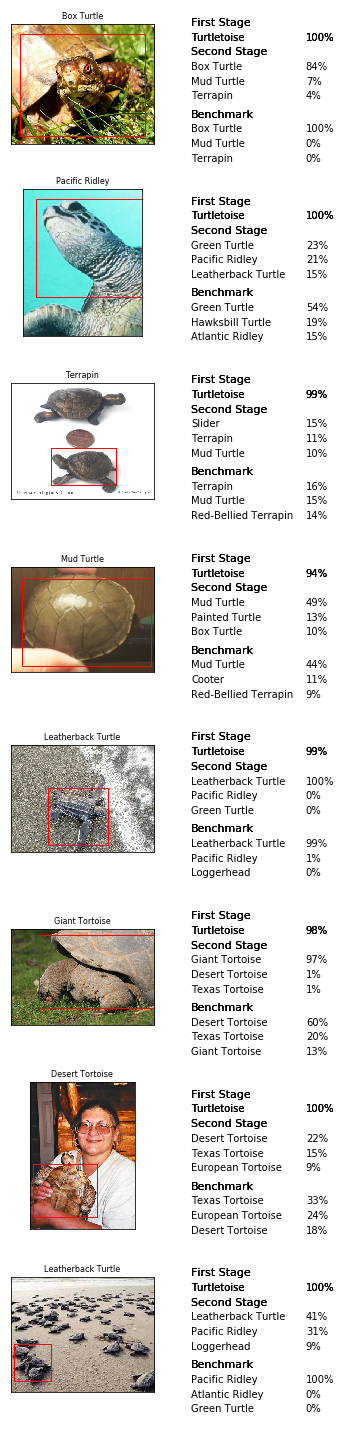

In [59]:
fig_ff